In [1]:
import os
import math
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.spatial import distance
from numpy import linalg as LA
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import metrics
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def uncertainity_mean(X_train1,pred,means,covariances,weights,km,numberofdimens):
    X_train1["pred"]=pred
    meanss=means
    weiths=weights
    variances=[]
    covariancematrix=covariances
    for i in covariancematrix: #The diagonal of cov is the variance of each gmm
        diag=np.diag(i)
        variances.append(diag)
    variances=np.array(variances)
    countiterations=0
    unc=[]
    un=[]

    sep=[]
    for g in range(0,len(meanss)):    ##Frechet distance
        for t in range(0,len(meanss)):
            if (t==g):
                continue
            else:
                sep.append(frechetDistance(meanss[t],meanss[g],covariancematrix[t],covariancematrix[g]))
    separation=np.array(sep)
    Dmin=np.array(separation).min()
    Dmax=np.array(separation).max()
    Sep=(Dmax/Dmin)*(1/separation.sum())

    for i in range(0,len(meanss)):    #Uncertainty    ##i run each cluster
        cweight=weiths[i]
        cmean=meanss[i]
        cvar=variances[i]
        lim_inf=cmean-(km*cvar)
        lim_sup=cmean+(km*cvar)
        unc=[]
        o=X_train1[X_train1["pred"]==i].iloc[:,:numberofdimens].copy()

        for j in range(len(o)): # j run each data
            DM=distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))
            varbool=(DM>=km)
            varunc=[]
            #print("varbool",varbool)
            if (varbool):
                varunc.append(2*km*DM)
            else:
                vs=((DM**2)+(km*DM)+(km**2)/2)
                varunc.append(vs)
        un.append(np.array(varunc))
    return np.sum(un)/Sep

In [3]:
def merguncertain (xtrain,y,Means,covariances,weights,numberofdimens):
    X_train11=xtrain
    X_train11["pred"]=y
    UNIndex=[]
    len(Means)
    Pairwise=np.ones((len(Means), len(Means)))
    labels=[]
    for i in range(len(Means)):
        labels.append(i)
        for j in range(len(Means)):
                if (i==j):
                    continue
                Pairwise[j,i]=(frechetDistance(Means[i],Means[j],covariances[i],covariances[j]))

    while len(Pairwise) > 2 :
            UNIndex.append(uncertainity_mean(X_train11.iloc[:,:numberofdimens],X_train11["pred"],Means,covariances,weights,1,numberofdimens))

            Similar_clusters=np.unravel_index(Pairwise.argmin(),Pairwise.shape)
            Similar_clusters_labels=( labels[Similar_clusters[0]],labels[Similar_clusters[1]])

            #update Mean
            data_size_1=len(X_train11[X_train11["pred"]==Similar_clusters_labels[0]])
            data_size_2=len(X_train11[X_train11["pred"]==Similar_clusters_labels[1]])
            mean_1=Means[Similar_clusters[0]]
            mean_2=Means[Similar_clusters[1]]
            new_mean = (data_size_1* mean_1 + data_size_2*mean_2)/(data_size_1 + data_size_2)
            Means[Similar_clusters[0]]=new_mean

            #Update labels
            X_train11["pred"]=X_train11["pred"].replace(Similar_clusters_labels[1], Similar_clusters_labels[0])
            #print(X_train11["pred"].unique())
            NewCovariance=X_train11[X_train11["pred"]==Similar_clusters_labels[0]].iloc[:,:numberofdimens].cov()
            covariances[Similar_clusters[0]]=NewCovariance
            weights[Similar_clusters[0]]=weights[Similar_clusters[0]]+weights[Similar_clusters[1]]

            updpairwisecolum=[]
            for j in range(0,len(Means)):
                    updpairwisecolum.append((frechetDistance(Means[Similar_clusters[0]],Means[j],covariances[Similar_clusters[0]],covariances[j])))
            #print(updpairwisecolum)
            Pairwise[:,Similar_clusters[0]]=updpairwisecolum
            Pairwise[Similar_clusters[0],:]=updpairwisecolum

            Means= np.delete(Means, (Similar_clusters[1]), axis=0)
            weights= np.delete(weights, (Similar_clusters[1]), axis=0)
            covariances=np.delete(covariances, (Similar_clusters[1]), axis=0)
            labels.remove(Similar_clusters_labels[1])
            Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=0)
            Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=1)
            np.fill_diagonal(Pairwise, 1)
    return UNIndex

In [4]:
def frechetDistance(u1,u2,E1,E2):
    return (LA.norm(np.absolute(u1-u2)**2))+np.trace(E1+E2-(2*(E1*E2)**(0.5)))

In [5]:
pwd

'/content'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

df=pd.read_csv('/content/drive/MyDrive/Doctorado/2023/Agosto/Daniel Nieto/X_UMAP.csv')

In [ ]:
df=df.iloc[:,1:]

## Approach 1: Calculating performance in base of index UF


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):

    X_train111=df.copy()
    GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
    X_train111["pred"]=GM.predict(X_train111)
    Means=GM.means_
    covariances=GM.covariances_
    weights=GM.weights_
    numberofdimens=X_train111.shape[1]-1
    y=X_train111["pred"]
    Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))


<Axes: xlabel='ind'>

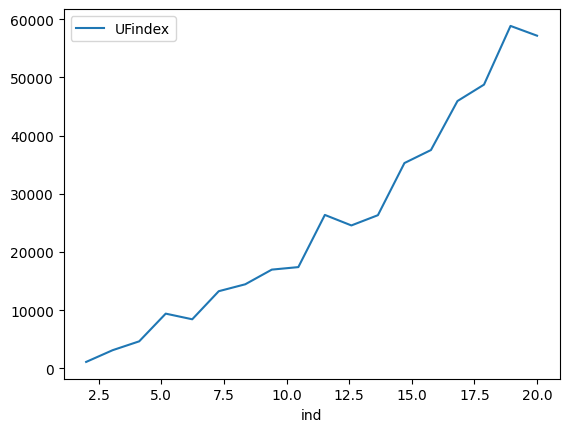

In [ ]:
change=pd.DataFrame(Index,columns=["UFindex"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["UFindex"])

In [ ]:
change["UFindex"].argmin()

0

## Approach 2: Meging methodology


<Axes: xlabel='ind'>

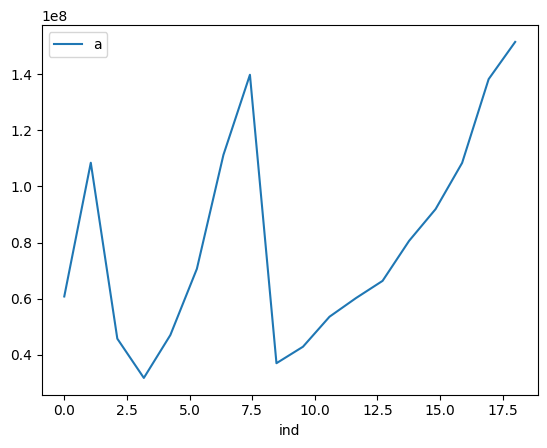

In [ ]:
from sklearn.model_selection import train_test_split

X=df
X_train111=df.copy()
GM = GaussianMixture(n_components=20, covariance_type="full", random_state=2).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(0,len(change),len(change))

change.plot("ind",["a"])


In [ ]:

change=change.iloc[:-1,:]

In [ ]:

recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

5

In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

df=pd.read_csv('/content/drive/MyDrive/Doctorado/2023/Agosto/Daniel Nieto/X_PCA.csv')

In [8]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
0,0,13.044993,-5.593243,-0.696683,3.662379,-0.139850,1.397526,-0.063161,-1.465234,0.641279,...,0.019893,0.039672,0.064869,-0.007133,-0.003154,0.052942,-0.143180,0.016084,0.041965,-0.144944
1,1,13.875603,-5.328022,-0.665485,4.617260,0.346263,1.968226,-0.531593,-1.299002,0.259782,...,0.121575,-0.109509,-0.122442,-0.397819,-0.255171,0.722521,0.198130,0.118104,-0.123503,-0.216296
2,2,14.163228,-4.024805,-1.698744,3.429611,1.149026,1.210555,-0.957066,-0.507815,-0.411193,...,0.298003,-0.492308,0.061939,-0.140935,0.001497,0.197287,0.413545,0.127607,-0.147375,-0.002372
3,3,13.339255,-5.152263,-1.238184,2.765433,0.338360,1.332335,-0.071660,-0.988279,0.347291,...,-0.112915,0.316427,0.312912,0.295916,-0.007619,-0.287507,-0.180218,-0.076333,-0.005957,-0.145642
4,4,13.032797,-5.614934,-0.873001,3.313101,-0.152759,1.348218,0.167714,-1.382820,0.526010,...,-0.773008,0.517045,-0.012045,0.213165,-0.114372,-0.624625,-0.203918,-0.176463,0.131390,0.000729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84815,84815,-6.467999,-0.248116,-0.875998,0.143440,1.353136,-2.378663,-0.730882,0.877220,-1.331696,...,-0.154823,-0.053806,-0.172043,0.275375,-0.446103,0.254066,-0.083799,0.034226,-0.208030,-0.261192
84816,84816,-5.337506,0.974563,-0.358455,-0.879336,-0.074972,-1.955175,-1.746127,0.314756,-1.072748,...,0.096165,0.242761,-0.262010,-0.386270,-0.052821,0.126551,-0.106586,-0.022384,-0.062952,-0.162167
84817,84817,-3.177078,2.026082,-0.916378,-2.305128,-2.788081,-0.980782,-2.227399,-0.687388,-1.470637,...,-0.146229,-0.124592,0.301288,-0.076214,0.047400,-0.045529,0.322252,-0.568262,-0.046207,0.448779
84818,84818,-5.394916,0.959071,-0.848343,-0.845878,-0.101228,-1.828374,-1.763605,-0.021771,-1.363137,...,0.245340,-0.225756,-0.286206,-0.226923,0.135791,0.212662,-0.076181,0.064242,-0.258144,-0.115306


In [9]:
df=df.iloc[:,1:10]

## Approach 1: Calculating performance in base of index UF


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):

    X_train111=df.copy()
    GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
    X_train111["pred"]=GM.predict(X_train111)
    Means=GM.means_
    covariances=GM.covariances_
    weights=GM.weights_
    numberofdimens=X_train111.shape[1]-1
    y=X_train111["pred"]
    Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))


<Axes: xlabel='ind'>

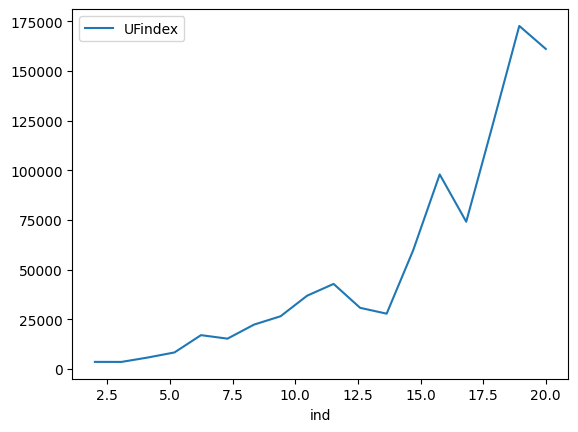

In [ ]:
change=pd.DataFrame(Index,columns=["UFindex"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["UFindex"])

In [ ]:
change["UFindex"].argmin()

1

## Approach 2: Meging methodology


In [ ]:
from sklearn.model_selection import train_test_split

X=df
X_train111=df.copy()
GM = GaussianMixture(n_components=20, covariance_type="full", random_state=2).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])

index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(0,len(change),len(change))

change.plot("ind",["a"])


<Axes: xlabel='ind'>

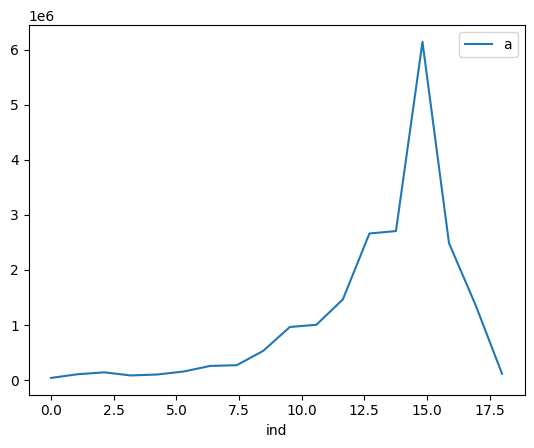

In [11]:
change.plot("ind",["a"])

In [12]:

change=change.iloc[:-1,:]

In [13]:

recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

2